# Purpose


This notebook generates plot which allow for the visualization of convergence via time block analysis of simulation observables. 

The resulting plots are featured, and more specifically the  in Figure 7.A and Figure S5 of the supporting information for the article DOI: 10.1021/acs.jctc.4c00294.

# Modules

In [1]:
# Basics
import sys
import os
import numpy as np
import pandas as pd
from collections import Counter
from typing import List, Dict

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm


# Specific to biomolecular simulations
import MDAnalysis as mda

# My functions
import functions as myfuncs

/home/forget/software/anaconda3/envs/mdaenv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/forget/software/anaconda3/envs/mdaenv2/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


# Charge dfs

In [2]:
# Load the data
my_path = "../Examples/"
my_name = "A_HairpinRibozyme_REST2_traj"

df = pd.read_csv(my_path + my_name + ".csv")

In [3]:
data_names = [
    "d_A-1:O2prime-G8:N1",
    "d_A-1:O2prime-A10:N6",
    "d_A-1:O2prime-A38:N6",
    "d_A-1:O2prime-G+1:O1P",
    "d_A-1:O2prime-G+1:O2P",
    "d_G+1:O1P-G8:N2",
    "d_G+1:O2P-G8:N2",
    "A-1_puckering_pseudorot",
    "IAA",
]

long_names = [
    "A-1:O2' - G8:N1",
    "A-1:O2' - A10:N6",
    "A-1:O2' - A38:N6",
    "A-1:O2'- G+1:pro-Sp",
    "A-1:O2' - G+1:pro-Rp",
    "G+1:pro-Sp - G8:N2",
    "G+1:pro-Rp - G8:N2",
    "A-1 pseudo-rotation (°)",
    "IAA (°)",
]

# Stats on States

## States

/tmp/ipykernel_3568287/2358600244.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  state_distribution_df = pd.concat(


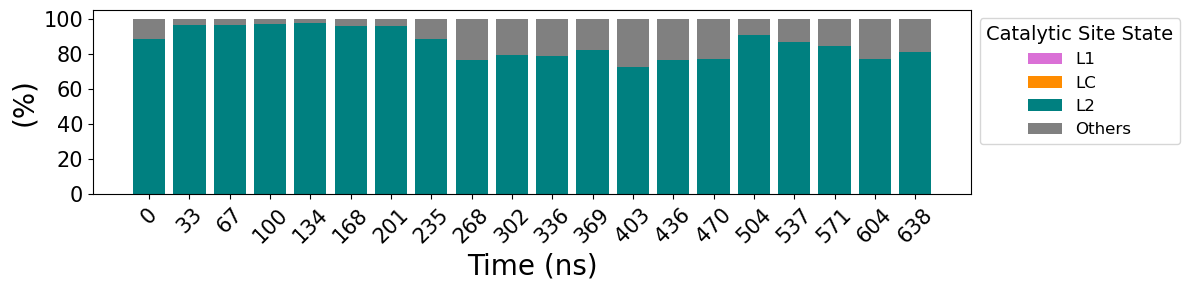

In [4]:
# Parameters
num_divisions: int = 20

# Plotting for this type of data:
state_labels: List[str] = ["L1", "LC", "L2", "Others"]
state_colors: List[str] = ["orchid", "darkorange", "teal", "grey"]

# Create time ranges
time_series: pd.Series = df["Time"]
time_step: int = int(time_series[1] - time_series[0])

time_segment_size: int = int(len(time_series) / num_divisions)
start_frames: List[int] = [i * time_segment_size for i in range(0, num_divisions)]
end_frames: List[int] = [(i + 1) * time_segment_size for i in range(0, num_divisions)]

time_ranges: List[str] = [str(int(start * time_step / 1000)) for start in start_frames]
time_range_centers: List[str] = [
    str(int(end * time_step / 1000 - start * time_step / 1000 / 2))
    for start, end in zip(start_frames, end_frames)
]

# Initialize dataframe for state distributions
state_distribution_df: pd.DataFrame = pd.DataFrame(columns=state_labels)

for start_frame, end_frame in zip(start_frames, end_frames):
    segment_data: pd.DataFrame = pd.DataFrame()

    for data_name in data_names:
        if data_name not in df.columns:
            print(f"Warning: '{data_name}' not found in dataframe columns.")
            continue
        segment_data[data_name] = df[data_name][start_frame:end_frame].values

    num_frames: int
    num_data_points: int
    num_frames, num_data_points = segment_data.shape

    # Determine state for each frame
    state_assignments: List[str] = []
    puckering_values: np.ndarray = segment_data["A-1_puckering_pseudorot"].values
    dist_g8: np.ndarray = segment_data["d_A-1:O2prime-G8:N1"].values
    dist_a38: np.ndarray = segment_data["d_A-1:O2prime-A38:N6"].values
    dist_a10: np.ndarray = segment_data["d_A-1:O2prime-A10:N6"].values
    dist_o1p: np.ndarray = segment_data["d_A-1:O2prime-G+1:O1P"].values
    dist_o2p: np.ndarray = segment_data["d_A-1:O2prime-G+1:O2P"].values

    for i in range(num_frames):
        if (
            (0 < puckering_values[i] < 43 or 339 < puckering_values[i])
            and dist_a38[i] < 3.5
            and dist_o2p[i] < dist_o1p[i]
        ):
            state_assignments.append("L2")
        elif (
            (0 < puckering_values[i] < 43 or 339 < puckering_values[i])
            and dist_a10[i] < 3.5
            and dist_o2p[i] < dist_o1p[i]
        ):
            state_assignments.append("L2")
        elif (
            138 < puckering_values[i] < 205
            and dist_g8[i] < 3.5
            and dist_o1p[i] < dist_o2p[i]
        ):
            state_assignments.append("L1")
        elif (
            138 < puckering_values[i] < 205
            and dist_g8[i] < 3.5
            and dist_o2p[i] < dist_o1p[i]
        ):
            state_assignments.append("LC")
        else:
            state_assignments.append("Others")

    segment_data["state_assignment"] = state_assignments

    # Compute percentage of each state
    state_percentages: Dict[str, float] = myfuncs.calculate_state_percentage(
        segment_data["state_assignment"], state_labels
    )
    state_distribution_df = pd.concat(
        [state_distribution_df, pd.DataFrame([state_percentages])], ignore_index=True
    )

state_distribution_df.index = time_ranges

# Plot the state distribution over time
fig, ax = plt.subplots(figsize=(12, 3))
state_distribution_transposed: pd.DataFrame = state_distribution_df.T

# Plot each row as a stacked bar chart
bottom_stack: np.ndarray = np.zeros(len(state_distribution_transposed.columns))

for color, (state, row_values) in zip(
    state_colors, state_distribution_transposed.iterrows()
):
    ax.bar(
        state_distribution_transposed.columns,
        row_values,
        label=state,
        bottom=bottom_stack,
        color=color,
    )
    bottom_stack += row_values

# Configure plot aesthetics
plt.xlabel("Time (ns)", fontsize=20)
plt.ylabel("(%)", fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

# Add legend outside the plot
plt.legend(
    title="Catalytic Site State",
    fontsize=12,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),  # Moves the legend outside the plot
)

plt.tight_layout()

# Save the plot
plt.savefig(
    f"{my_path}{my_name}_catalytic-site-states-vs-time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## Pucker

/tmp/ipykernel_3568287/3572172291.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  state_distribution_df = pd.concat(


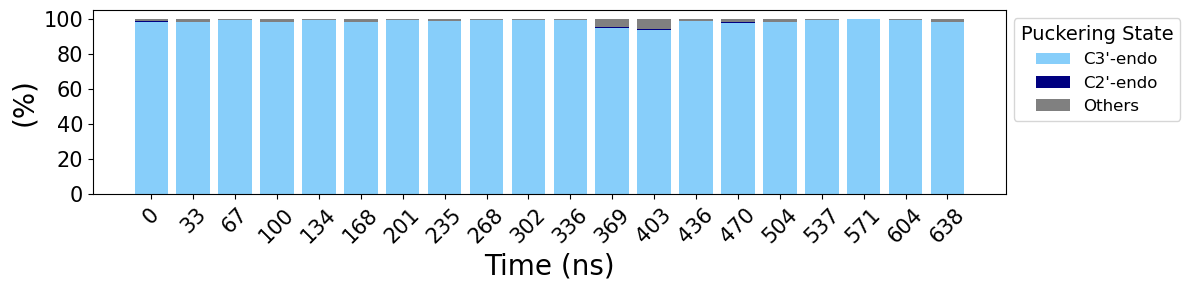

In [5]:
# Parameters
num_divisions: int = 20  # Number of time divisions

# Define states and corresponding colors
state_labels: List[str] = ["C3'-endo", "C2'-endo", "Others"]
state_colors: List[str] = ["lightskyblue", "navy", "grey"]

# Extract time series data
time_series: pd.Series = df["Time"]
time_step: int = int(time_series[1] - time_series[0])  # Assuming uniform time steps

# Determine frame division size
division_size: int = len(time_series) // num_divisions

# Create start and end frame lists
start_frames: List[int] = [i * division_size for i in range(0, num_divisions)]
end_frames: List[int] = [(i + 1) * division_size for i in range(0, num_divisions)]

# Generate time range labels for plotting (in nanoseconds)
time_ranges: List[str] = [
    str(int(start_frames[s] * time_step / 1000)) for s in range(len(start_frames))
]

# Calculate range centers
range_centers: List[str] = [
    str(int(end_frames[s] * time_step / 1000 - start_frames[s] * time_step / 1000 / 2))
    for s in range(len(start_frames))
]

# Initialize dataframe for states
state_distribution_df: pd.DataFrame = pd.DataFrame(columns=state_labels)

# Process each time range
for index in range(len(start_frames)):
    start_frame: int = start_frames[index]
    end_frame: int = end_frames[index]

    # Extract relevant data from dataframe
    temp_data: pd.DataFrame = pd.DataFrame()
    for data_name in data_names:
        if data_name not in df.columns:
            print(f"Warning: '{data_name}' not found in dataframe columns.")
            continue
        temp_data[data_name] = df[data_name][start_frame:end_frame]

    num_frames, num_data_columns = temp_data.shape

    # Classify puckering states
    puckering_states: List[str] = []
    puckering_values: np.ndarray = temp_data["A-1_puckering_pseudorot"].values

    for frame_index in range(num_frames):
        if (
            0 < puckering_values[frame_index] < 43
            or puckering_values[frame_index] > 339
        ):
            puckering_states.append("C3'-endo")
        elif 138 < puckering_values[frame_index] < 205:
            puckering_states.append("C2'-endo")
        else:
            puckering_states.append("Others")

    temp_data["States"] = puckering_states

    # Compute state percentage distributions
    state_percentages: Dict[str, float] = myfuncs.calculate_state_percentage(
        temp_data["States"], state_labels
    )

    # Append results to state distribution dataframe
    percentage_data = {
        "C3'-endo": [state_percentages["C3'-endo"]],
        "C2'-endo": [state_percentages["C2'-endo"]],
        "Others": [state_percentages["Others"]],
    }
    state_distribution_df = pd.concat(
        [state_distribution_df, pd.DataFrame(percentage_data)], ignore_index=True
    )

# Assign index labels
state_distribution_df.index = time_ranges

# Plot the state distributions over time
fig, ax = plt.subplots(figsize=(12, 3))
transposed_state_df: pd.DataFrame = state_distribution_df.T

# Create stacked bar plot
bottom_values: np.ndarray = np.zeros(len(transposed_state_df.columns))

for color_index, (state_label, row_values) in enumerate(transposed_state_df.iterrows()):
    ax.bar(
        transposed_state_df.columns,
        row_values,
        label=state_label,
        bottom=bottom_values,
        color=state_colors[color_index],
    )
    bottom_values += row_values

# Customize plot appearance
plt.xlabel("Time (ns)", fontsize=20)
plt.ylabel("(%)", fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(
    title="Puckering State",
    fontsize=12,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

plt.tight_layout()

# Save and display the figure
output_image_path: str = f"{my_path}{my_name}_puckering-states-vs-time.png"
plt.savefig(output_image_path, dpi=300, bbox_inches="tight")
plt.show()

## Tau 2

/tmp/ipykernel_3568287/1900915170.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  states_df = pd.concat([states_df, pd.DataFrame(per_data)], ignore_index=True)


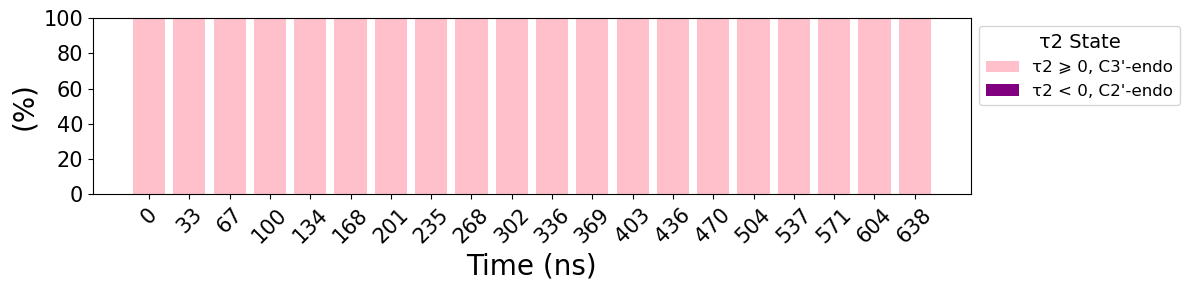

In [8]:
# Parameters
divide_in: int = 20

# Create time ranges for this type of data :
states_list: List[str] = ["\u03c42 \u2a7e 0, C3'-endo", "\u03c42 < 0, C2'-endo"]
colors: List[str] = ["pink", "purple", "grey"]

# Create time ranges
time: pd.Series = df["Time"]
step: int = int(time[1] - time[0])

div: int = int(len(time) / divide_in)
start_frames: List[int] = [i * div for i in range(0, int(len(time) / div))]
end_frames: List[int] = [(i + 1) * div for i in range(0, int(len(time) / div))]

ranges: List[str] = [
    str(int(start_frames[s] * step / 1000)) for s in range(len(start_frames))
]

range_centers: List[str] = [
    str(int(end_frames[s] * step / 1000 - start_frames[s] * step / 1000 / 2))
    for s in range(len(start_frames))
]

# Fill states dataframe
states_df: pd.DataFrame = pd.DataFrame(columns=states_list)

for s in range(len(start_frames)):
    start_frame: int = start_frames[s]
    end_frame: int = end_frames[s]

    data: pd.DataFrame = pd.DataFrame()
    for data_name in data_names:
        if data_name not in df.columns:
            print("Data not in columns")
        values: pd.Series = df[data_name]
        data["tau2"] = values[start_frame:end_frame]

    nb_of_frames, nb_datas = data.shape

    states: List[str] = []
    tau2: np.ndarray = data["tau2"].values
    flag_c3_endo: bool = False
    flag_c2_endo: bool = False

    for s in range(nb_of_frames):
        if tau2[s] < 0:
            states.append("\u03c42 < 0, C2'-endo")
            flag_c2_endo = True
        else:
            states.append("\u03c42 \u2a7e 0, C3'-endo")
            flag_c3_endo = True

    data["States"] = states
    percentage_series: Dict[str, float] = myfuncs.calculate_state_percentage(
        data["States"], states_list
    )

    if not flag_c2_endo:
        percentage_series["\u03c42 < 0, C2'-endo"] = 0
    if not flag_c3_endo:
        percentage_series["\u03c42 \u2a7e 0, C3'-endo"] = 0

    per_data: Dict[str, List[float]] = {
        "\u03c42 \u2a7e 0, C3'-endo": [percentage_series["\u03c42 \u2a7e 0, C3'-endo"]],
        "\u03c42 < 0, C2'-endo": [percentage_series["\u03c42 < 0, C2'-endo"]],
    }

    states_df = pd.concat([states_df, pd.DataFrame(per_data)], ignore_index=True)

states_df.index = ranges

# Plot the data
fig, ax = plt.subplots(figsize=(12, 3))
states_t_df: pd.DataFrame = states_df.T

# Plot each row as a stacked bar
bottom: np.ndarray = np.zeros(len(states_t_df.columns))

for c, (idx, row) in enumerate(states_t_df.iterrows()):
    ax.bar(states_t_df.columns, row, label=idx, bottom=bottom, color=colors[c])
    bottom += row

plt.xlabel("Time (ns)", fontsize=20)
plt.ylabel("(%)", fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

plt.legend(
    title="\u03c42 State",
    fontsize=12,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

plt.tight_layout()

plt.savefig(
    my_path + my_name + "_tau2-states-vs-time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()